# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API

In [40]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats.distributions import genpareto
from scipy import special
from scipy import optimize
import itertools

import logging
LOG = logging.getLogger(__name__)
import warnings

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-116.84375 36.21875)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [38]:
# Download observed daily timeseries
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

observedDF = get_observed()
observedDF

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.000000,livneh,1950,1,1950
1950-01-02,0.000000,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.005531,livneh,1950,1,1950
1950-01-08,0.051316,livneh,1950,1,1950
1950-01-09,0.019359,livneh,1950,1,1950
1950-01-10,0.000000,livneh,1950,1,1950


In [41]:
# Download projected daily timeseries. The projected daily timeseries are from 2006 - 2099/2100
# and units are in kg/m2/s.
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CNRM-CM5']
    scenarios = ['rcp45', 'rcp85']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

projectedDF = get_projections()
projectedDF

Processing: pr_day_CNRM-CM5_rcp45
Processing: pr_day_CNRM-CM5_rcp85


,value,series,year,month,wateryear
2006-01-01,0.000000,CNRM-CM5,2006,1,2006
2006-01-02,0.000000,CNRM-CM5,2006,1,2006
2006-01-03,0.000000,CNRM-CM5,2006,1,2006
2006-01-04,0.000000,CNRM-CM5,2006,1,2006
2006-01-05,0.000000,CNRM-CM5,2006,1,2006
2006-01-06,0.000000,CNRM-CM5,2006,1,2006
2006-01-07,0.000000,CNRM-CM5,2006,1,2006
2006-01-08,0.000000,CNRM-CM5,2006,1,2006
2006-01-09,0.000000,CNRM-CM5,2006,1,2006
2006-01-10,0.000000,CNRM-CM5,2006,1,2006


We now have 2 dataframes (`observedDF` and `projectionsDF`) that hold observed historical and modeled future daily precipitation data. We will use the observed historical daily values for water years 1961-1990 as the baseline timeperiod for the Extreme Value Analysis

----
# Extreme Value Analysis using Peak Over Threshold (POT)
----

For this example we will define an Extreme Precipitation event as a 2-day accumulation event.

### Calculate 2-day precipitation totals for the baseline period

In [297]:
# Filter data by baseline time period
baselineDF = observedDF.loc[(observedDF['wateryear'] >= 1961) & (observedDF['wateryear'] <= 1990)]
baselineDF = pd.DataFrame(baselineDF)

In [298]:
# Duration of an extreme precipitation event
duration = 1

In [326]:
# Calculate 2-day rainfall totals
baselineDF['total_precip'] = baselineDF['value'].rolling(duration).sum()
baselineDF

,value,series,year,month,wateryear,total_precip,exceedance,consecutive
1960-10-01,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-02,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-03,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-04,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-05,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-06,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-07,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-08,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-09,0.036108,livneh,1960,10,1961,3.610821e-02,0.0,1
1960-10-10,0.061072,livneh,1960,10,1961,6.107190e-02,0.0,1


### Select a threshold value

Different methods have been proposed in literature for the selection of an appropriate threshold. In this example, we use the lowest value from the Annual Maximum Series for the baseline timeperiod. Another option is to use quantiles. One of the issues we noticed with using high quantiles as a threshold was that arid locations in California had too few exceedances over this threshold to meet requirements of statistical tests.

In [327]:
# Create Annual Maximum Series
AMS = baselineDF.groupby('wateryear').total_precip.max()
AMS

wateryear
1961    0.427277
1962    0.111075
1963    0.266960
1964    0.228767
1965    0.240478
1966    0.210483
1967    0.101261
1968    0.284471
1969    0.299536
1970    0.138767
1971    0.399189
1972    0.128120
1973    0.380452
1974    0.345619
1975    0.195383
1976    0.305236
1977    0.518160
1978    0.290832
1979    0.105706
1980    0.352646
1981    0.112261
1982    0.234454
1983    0.334194
1984    0.823606
1985    0.187604
1986    0.116607
1987    0.183936
1988    0.507942
1989    0.088499
1990    0.184330
Name: total_precip, dtype: float64

In [328]:
minAMS = np.min(AMS)
print('Lowest value from Annual Maximum Series =', minAMS, 'inch/day')

# If you want to use a percentile as threshold, use the following code:
# Remove zero precipitation events
baseline_nonzero = baselineDF.loc[(baselineDF['total_precip'] > 0)]
# Calculate 95th percentile
quantile95 = baseline_nonzero['total_precip'].quantile(0.95, interpolation='linear')
print('95th Percentile =', quantile95, 'inch/day')

Lowest value from Annual Maximum Series = 0.08849935354476007 inch/day
95th Percentile = 0.027098249111929693 inch/day


In [329]:
# Set threshold value to lowest value of Annual Maximum Series
threshold = round(minAMS, 2)
print(threshold)

0.09


### Remove correlated events

Add a new column which identifies consecutive (back-to-back) extreme events. We will take the largest of the consecutive values above the selection threshold to create our Partial Duration Series (Wilks, Daniel S., Statistical Methods in the Atmospheric Sciences, 2001).

Add a column which indicates whether the event exceeds selected threshold

In [335]:
baselineDF.loc[baselineDF['total_precip'] > threshold, 'exceedance'] = 1
baselineDF.loc[baselineDF['total_precip'] <= threshold, 'exceedance'] = 0 
baselineDF

,value,series,year,month,wateryear,total_precip,exceedance,consecutive
1960-10-01,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-02,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-03,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-04,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-05,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-06,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-07,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-08,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-09,0.036108,livneh,1960,10,1961,3.610821e-02,0.0,1
1960-10-10,0.061072,livneh,1960,10,1961,6.107190e-02,0.0,1


Add a new column which identifies consecutive (back-to-back) extreme events. We will take the largest of the consecutive values above the selection threshold to create our Partial Duration Series (Wilks, Daniel S., Statistical Methods in the Atmospheric Sciences, 2001).

In [336]:
baselineDF['consecutive'] = (baselineDF.exceedance.shift(1) != baselineDF.exceedance).astype(int).cumsum()
baselineDF

,value,series,year,month,wateryear,total_precip,exceedance,consecutive
1960-10-01,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-02,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-03,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-04,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-05,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-06,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-07,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-08,0.000000,livneh,1960,10,1961,0.000000e+00,0.0,1
1960-10-09,0.036108,livneh,1960,10,1961,3.610821e-02,0.0,1
1960-10-10,0.061072,livneh,1960,10,1961,6.107190e-02,0.0,1


In [337]:
# Drop NaN values
baselineDF = baselineDF.dropna()

In [338]:
# Adapted from https://stackoverflow.com/questions/27488080/python-pandas-filter-rows-after-groupby
# Here, idxmax() finds the indices of the rows with max value within groups,
# and .loc() filters the rows using those indices :
exceedances = baselineDF[baselineDF['exceedance'] > 0]
largest_consecutive_exceedances = exceedances.loc[exceedances.groupby(['consecutive'])['total_precip'].idxmax()]
largest_consecutive_exceedances

,value,series,year,month,wateryear,total_precip,exceedance,consecutive
1960-11-06,0.427277,livneh,1960,11,1961,0.427277,1.0,2
1961-01-26,0.146882,livneh,1961,1,1961,0.146882,1.0,4
1961-08-22,0.105660,livneh,1961,8,1961,0.105660,1.0,6
1961-11-25,0.111075,livneh,1961,11,1962,0.111075,1.0,8
1961-12-02,0.090599,livneh,1961,12,1962,0.090599,1.0,10
1962-02-19,0.093089,livneh,1962,2,1962,0.093089,1.0,12
1963-02-10,0.185600,livneh,1963,2,1963,0.185600,1.0,14
1963-09-05,0.093993,livneh,1963,9,1963,0.093993,1.0,16
1963-09-18,0.266960,livneh,1963,9,1963,0.266960,1.0,18
1963-11-21,0.090647,livneh,1963,11,1964,0.090647,1.0,20


In [339]:
# Create a Partial duration series
PDS = largest_consecutive_exceedances['total_precip'].values
print('Number of exceedances =', len(PDS))

Number of exceedances = 125


In [309]:
# Functions adapted from https://github.com/wcarthur/extremes

def returnLevels(intervals, mu, xi, sigma, rate, npyr):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.

    :returns: return levels for the specified recurrence intervals.

    """

    rlevels = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    return rlevels

def empReturnPeriod(data, npyr):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.

    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.

    The highest return period should be (approximately) len(``data``)/``npyr``.

    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)

    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

In [310]:
def fitData(data, mu):
    """
    Calculate parameter estimates for shape and scale while holding the location at threshold value.
    Freeze the distribution using these parameters estimates.
    :param data: :class:`numpy.ndarray` of data values (partial duration series)
    :param float mu: Threshold value
    :returns: Frozen distribution and parameter estimates
    """
    LOG.debug("Fitting data")
    params = genpareto.fit(data[data > mu], floc=mu)
    fit = genpareto(*params)
    return (fit, params)

In [325]:
def plotDiagnostics(data, mu):
    """
    Create a 4-panel diagnostics plot of the fitted distribution.
    :param data: :class:`numpy.ndarray` of observed data values
    :param float mu: Selected threshold value.
    """
    LOG.info("Plotting diagnostics")
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    axes = ax.flatten()
    
    # Get the frozen distribution object and parameter estimates
    gpa_fit, params = fitData(data, mu)
    
    exceedances = np.sort(data[data > mu])
    
    # PROBABILITY PLOT
    N = len(exceedances)
    x = gpa_fit.cdf(exceedances)
    y = np.arange(1, N + 1) / (N + 1)
    
    ax0 = axes[0]
    ax0.scatter(x, y, color = 'r')
    ax0.plot([0, 1], [0, 1])
    ax0.set_xlim(0, 1)
    ax0.set_ylim(0, 1)
    ax0.set_xlabel('Model')
    ax0.set_ylabel('Empirical')
    ax0.set_title('Probability Plot')


    # QUANTILE PLOT
    # Not sure if this is the correct way to plot quantile plot
    vals = np.arange(0.1, 1, 0.01)
    x = gpa_fit.ppf(vals)
    y = genpareto.ppf(vals, c=0.1, loc=mu)
    
    ax1 = axes[1]
    ax1.scatter(x, y, color = 'r')
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Empirical")
    ax1.set_title('Quantile Plot')

    # RETURN LEVEL PLOT
    # Return periods/intervals
    rp = np.array([1, 2, 5, 10, 20, 50, 100])
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(exceedances)) / float(len(data))
    # Number of observations per year. We are looking at a 30 year period in this example.
    npyr = len(data) / 30
    # Return levels
    rval = returnLevels(rp, mu, params[0], params[2], rate, npyr)
    # Empirical return levels
    emprp = empReturnPeriod(data, npyr)
    sorted_data = np.sort(data)
    
    ax2 = axes[2]
    ax2.semilogx(rp, rval, label="Fitted RP curve")
    ax2.scatter(emprp[emprp > 1], sorted_data[emprp > 1], color='r', label="Empirical RP", s=100)
    ax2.set_xlabel("Return period")
    ax2.set_ylabel("Return level")
    ax2.set_title("Return level plot")
    ax2.legend(loc='best', frameon=False)
    ax2.grid(True)
    
    # DENSITY PLOT
    x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)
    
    ax3 = axes[3]
    ax3.plot(x, gpa_fit.pdf(x), label = 'Modeled')
    ax3.hist(exceedances, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
    ax3.set_xlabel('Precipitation')
    ax3.set_ylabel('Probability')
    ax3.set_title('Density Plot')
    ax3.legend(loc='best', frameon=False)
    
    plt.tight_layout()

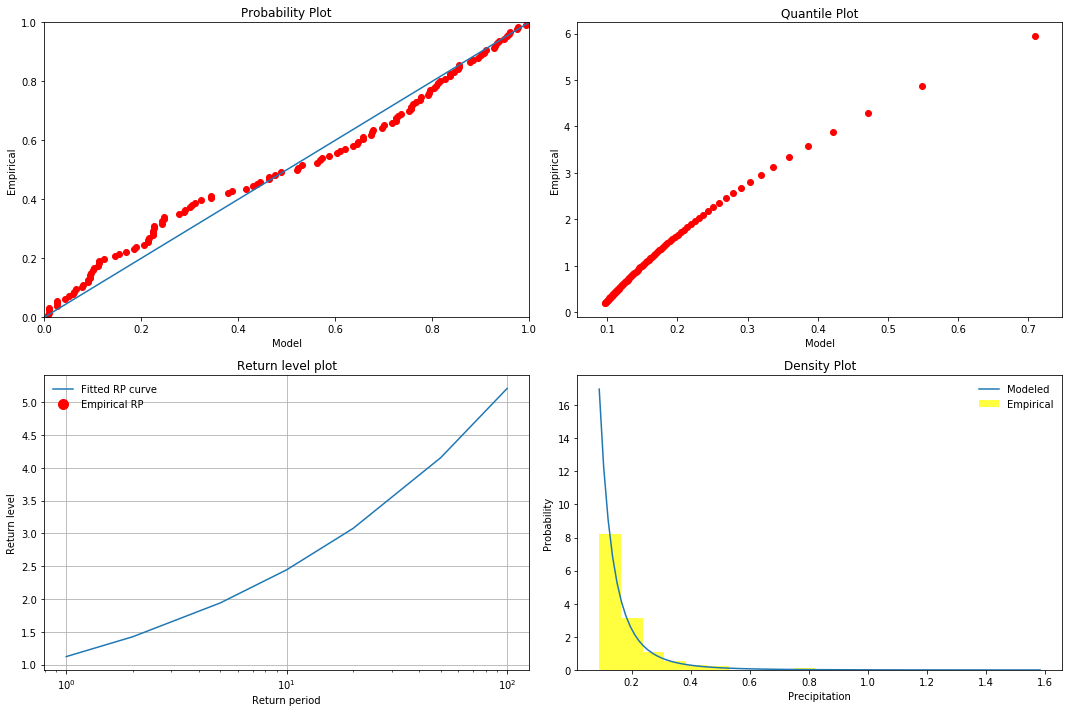

In [320]:
plotDiagnostics(PDS, threshold)

---
# Calculating Profile Likelihood Confidence Intervals for a Return Level
---

### Results from eva package using Profile method for location POINT(-121.4687 38.5938)

| RP | Estimate | CI |
| :------------- | :----------: | -----------: |
|2 | 1.850149 | 1.682067 2.100018 |
|5 | 2.351029 | 2.066932 2.845611 |
|10 | 2.773079 | 2.362567 3.554957 |
|20 | 3.236324 | 2.661167 4.418990 |
|50 | 3.918808 | 3.060282 5.855717 |
|100 | 4.493882 | 3.365654 7.219048 |

The following function calculates the return level and confidence intervals for one interval at time.


In [321]:
# Function adapted from R library eva - https://github.com/geekman1/eva_package/blob/master/R/gpdRl.R

def returnLevelWithCI(period, mu, xi, sigma, data, conf=0.95):
    """
    Calculate return level with Confidence Interval for a specified period for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param float period: Recurrence interval
    :param float mu: Threshold parameter (also called location).
    :param float sigma: Scale parameter.
    :param float xi: Shape parameter.
    :param ndarray data: Partial Duration Series
    :param float conf: The confidence level used.
    :returns: return level for the specified recurrence interval.

    """
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(data[data > mu])) / float(len(data))
    # Number of observations per year.
    npyr = len(data) / 30
    m = period * npyr
    # Quantile of chi**2 distribution
    cutoff =  special.chdtri(1, 1 - conf)
    # Sum of log of the probability density function for dataset
    lmax = np.sum(genpareto.logpdf(data[data > mu], c=xi, loc=mu, scale=sigma))
    # The largest in magnitude usable floating value.
    XMAX = np.finfo(float).max
    
    # Log Likelihood function
    def gpdlik(shape, xp):
        if (shape == 0):
            scale = (xp - mu) / np.log(m * rate)
        else:
            scale = ((xp - mu) * shape) / (np.power(m * rate, shape) - 1)
        
        if (scale <= 0):
            out = XMAX
        else:
            out = genpareto.logpdf(data[data > mu], c=shape, loc=mu, scale=scale)
            out = np.sum(out)
            if(out == float('Inf')):
                out = XMAX
        return -out

    # Profile Likelihood function
    def prof(xp):
        yes = optimize.minimize(gpdlik, [xi], args=(xp,))
        lci = -yes.fun
        return 2*(lmax-lci) - cutoff
    
    # Calculate return level
    est = mu + (sigma / xi) * (np.power(m * rate, xi) - 1.)
    print('Return Level estimate for {} year return period: {}'.format(period, est))
    
    # Guess for initial bounds. Don't know if these guesses will work for all locations. 
    lower_bound = est**0.5
    upper_bound = est**2
    
    # Calculate confidence intervals
    try:
        ci_upper = optimize.brentq(prof, est, upper_bound)
        print('Confidence Interval (upper) =', ci_upper)
    except ValueError as e:
        print('Confidence Interval (upper):', e)
    
    try:
        ci_lower = optimize.brentq(prof, est, lower_bound)
        print('Confidence Interval (lower) =', ci_lower)
    except ValueError as e:
        print('Confidence Interval (lower):', e)

In [322]:
warnings.filterwarnings('ignore')
# Get the frozen distribution object and parameter estimates
gpa_fit, params = fitData(PDS, threshold)
returnLevelWithCI(100, threshold, params[0], params[2], PDS)

Return Level estimate for 100 year return period: 1.1734669771929431
Confidence Interval (upper): f(a) and f(b) must have different signs
Confidence Interval (lower): f(a) and f(b) must have different signs


In [323]:
# Function adapted from R library eva - https://github.com/geekman1/eva_package/blob/master/R/gpdRl.R

def returnLevelWithCI2(period, mu, xi, sigma, data, conf=0.95):
    """
    Calculate return level with Confidence Interval for a specified period for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param float period: Recurrence interval
    :param float mu: Threshold parameter (also called location).
    :param float sigma: Scale parameter.
    :param float xi: Shape parameter.
    :param ndarray data: Partial Duration Series
    :param float conf: The confidence level used.
    :returns: return level for the specified recurrence interval.

    """
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(data[data > mu])) / float(len(data))
    # Number of observations per year.
    npyr = len(data) / 30
    m = period * npyr
    # Quantile of chi**2 distribution
    cutoff =  special.chdtri(1, 1 - conf)
    # Sum of log of the probability density function for dataset
    lmax = np.sum(genpareto.logpdf(data[data > mu], c=xi, loc=mu, scale=sigma))
    # The largest in magnitude usable floating value.
    XMAX = np.finfo(float).max
    
    # Log Likelihood function
    def gpdlik(shape, xp):
        if (shape == 0):
            scale = (xp - mu) / np.log(m * rate)
        else:
            scale = ((xp - mu) * shape) / (np.power(m * rate, shape) - 1)
        
        if (scale <= 0):
            out = XMAX
        else:
            out = genpareto.logpdf(data[data > mu], c=shape, loc=mu, scale=scale)
            out = np.sum(out)
            if(out == float('Inf')):
                out = XMAX
        return -out

    # Profile Likelihood function
    def prof(xp):
        yes = optimize.minimize(gpdlik, [xi], args=(xp,))
        lci = -yes.fun
        return 2*(lmax-lci) - cutoff
    
    # Calculate return level
    est = mu + (sigma / xi) * (np.power(m * rate, xi) - 1.)
    print('Return Level for {} year return period: {}'.format(period, est))
    
    # Plot the prof function
    def graph(formula, x_range, root):  
        x = np.array(x_range) 
        y = []
        for i in x:
            y.append(formula(i))
        plt.plot(x, y)
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(y=0, color='b', linestyle='--', linewidth=1)
        plt.axvline(x=root, color='b', linestyle='--', linewidth=1)
        plt.show()
    
    # Calculate confidence intervals
    step = 0.005 # increases the interval by this amount till root is found
    max_iterations = 5000 # maximum number of iterations
    
    # The EVA package uses the uniroot R function to find the upper and lower confidence intervals
    # The uniroot function searches the interval from lower to upper for a root (i.e., zero) of the function f 
    # with respect to its first argument. It has an attribute extendInt, which will extend the interval
    # if sign(f(x)) does not satisfy the requirements at the interval end points. There is no equivalent 
    # function in SciPy. The code below tries to recreate functionality similiar to uniroot by retrying the 
    # brentq optimzation till a root is reached by extending the interval bounds. The code is not very 
    # efficient but it seems to work for all the edge cases.
    
    # Upper confidence interval
    ci_upper = None
    def calculate_ci_upper(upper_bound, retries=0):
        if retries > max_iterations:
            raise Exception('Maximum number of iterations excedded')
        try:
            result = optimize.brentq(prof, est, upper_bound, xtol=step)
            return result, upper_bound
        except:
            retries+=1
            upper_bound = upper_bound + step
            return calculate_ci_upper(upper_bound, retries)

    try:
        ci_upper, upper_bound = calculate_ci_upper(est + 0.005)
        graph(prof, np.arange(est, upper_bound, step), root=ci_upper)
        print('Profile Graph for Confidence Interval (upper) =', ci_upper)
    except Exception as e:
        print('Confidence Interval (upper):', e)
    
    # Lower confidence interval
    ci_lower = None
    def calculate_ci_lower(lower_bound, retries=0):
        if retries > max_iterations:
            raise Exception('Maximum number of iterations excedded')
        try:
            result = optimize.brentq(prof, lower_bound, est, xtol=step)
            return result, lower_bound
        except:
            retries+=1
            lower_bound = lower_bound - step
            return calculate_ci_lower(lower_bound, retries)

    try:
        ci_lower, lower_bound = calculate_ci_lower(est - 0.005)
        graph(prof, np.arange(lower_bound, est, step), root=ci_lower)
        print('Profile Graph for Confidence Interval (lower) =', ci_lower)
    except Exception as e:
        print('Confidence Interval (lower):', e)

Return Level for 100 year return period: 1.1734669771929431


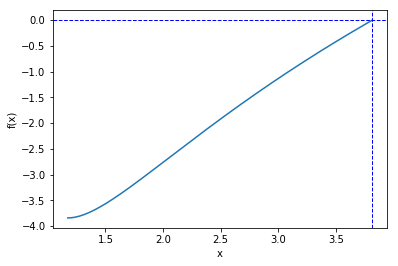

Profile Graph for Confidence Interval (upper) = 3.8159669771928852


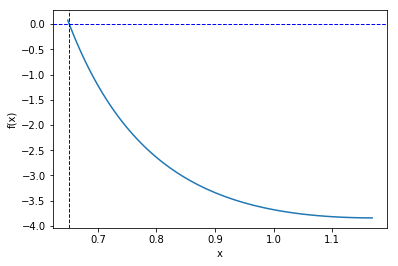

Profile Graph for Confidence Interval (lower) = 0.6510064241601747


In [324]:
warnings.filterwarnings('ignore')
returnLevelWithCI2(100, threshold, params[0], params[2], PDS)